In [1]:
#import dependencies
from citipy import citipy
import pandas as pd
import random
from config import api_key
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
#setup lists to hold our random long and lats
random_long = []
random_lat = []

#count to 500, generate a random list of longitudes and latitudes
i = 1
while i <= 500:
    random_long.append(random.randint(-180, 80))
    random_lat.append(random.randint(-90, 90))
    #per https://knowledge.domo.com/Visualize/Adding_Cards_to_Domo/KPI_Cards/Building_Each_Chart_Type/Latitude-Longitude_Map
    #longitude ranges from -180 to 80 and latitude ranges from -90 to 90
    i = i + 1

In [3]:
#empty list of cities
list_of_cities = []

#run through our random lat and longs, find the closest city via citipy
j = 0
while j <= 499:
    city = citipy.nearest_city(random_lat[j],random_long[j])
    list_of_cities.append(str(city.city_name))
    j = j + 1

In [4]:
#openweath URL and the parameters
url = "http://api.openweathermap.org/data/2.5/weather?"
query_url = f"{url}appid={api_key}&units=imperial&q="

#blank lists to hold the data
list_of_long = []
list_of_lat = []
list_of_temp = []
list_of_humid = []
list_of_cloudy = []
list_of_wind = []

#count to 500, pull the results, save to lists
k = 0
while k <= 499:
    f"Trying to find {list_of_cities[k]} which is city #{k+1}"
    response = requests.get(query_url + list_of_cities[k]).json()
    try:
        list_of_long.append(response['coord']['lon'])
        list_of_lat.append(response['coord']['lat'])
        list_of_temp.append(response['main']['temp'])
        list_of_humid.append(response['main']['humidity'])
        list_of_cloudy.append(response['clouds']['all'])
        list_of_wind.append(response['wind']['speed'])
        k = k + 1
    #error capture, if openweather can't find the city name, delete the city name from the list and generate a new random long/lat and get a new city name
    except KeyError:
        f"Ooops, can't find {list_of_cities[k]}!"
        city_to_delete = list_of_cities[k]
        list_of_cities.remove(city_to_delete)
        new_long = random.randint(-180, 80)
        new_lat = random.randint(-90, 90)
        new_city = citipy.nearest_city(new_lat,new_long)
        list_of_cities.append(str(new_city.city_name))

Text(0.5, 0, 'Latitude')

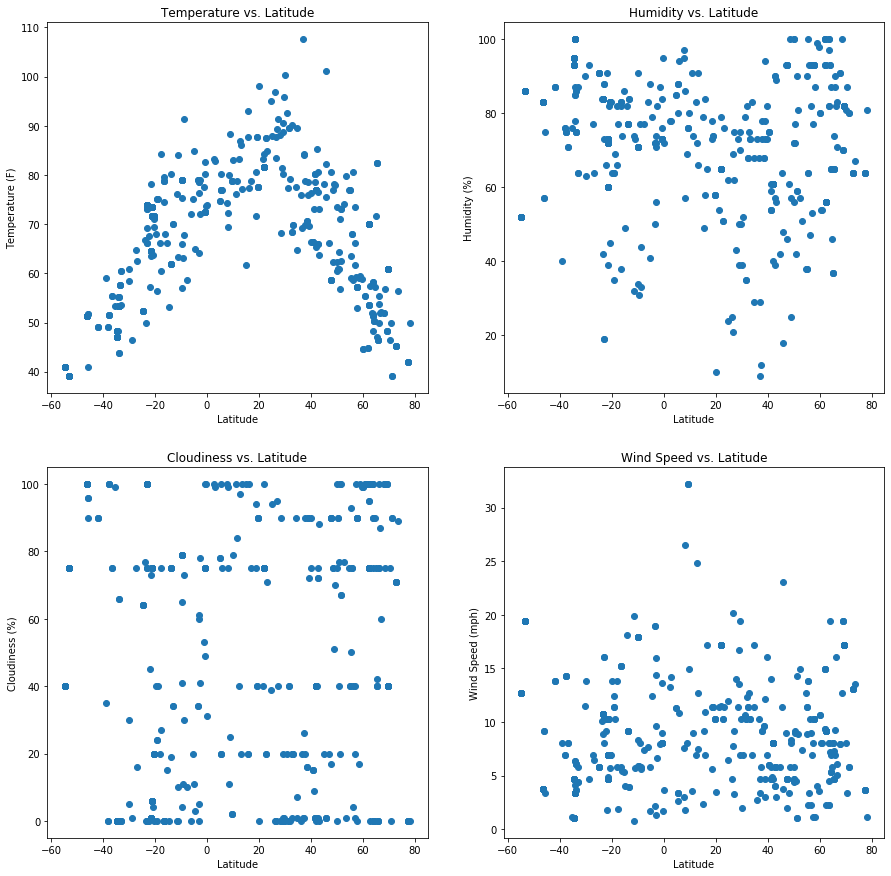

In [5]:
#create scatter plots
fig, axs = plt.subplots(2, 2, figsize=(15,15))

axs[0, 0].scatter(list_of_lat, list_of_temp)
axs[0, 0].set_title('Temperature vs. Latitude')
axs[0, 0].set_ylabel('Temperature (F)')
axs[0, 0].set_xlabel('Latitude')
#There are highest temperatures near the equator, and then decrease as you approach the pole

axs[0, 1].scatter(list_of_lat, list_of_humid)
axs[0, 1].set_title('Humidity vs. Latitude')
axs[0, 1].set_ylabel('Humidity (%)')
axs[0, 1].set_xlabel('Latitude')
#no correlation between humidity and latitude, probably dependant on other things like climate, local topgraphy and elevation, etc.

axs[1, 0].scatter(list_of_lat, list_of_cloudy)
axs[1, 0].set_title('Cloudiness vs. Latitude')
axs[1, 0].set_ylabel('Cloudiness (%)')
axs[1, 0].set_xlabel('Latitude')
#hard to find a correlation between cloudiness and latitude. OpenWeather must have preset cloudiness percentages which is why many are plotting to lines ("mostly cloudy" returns a value of 75%, "partly cloudy" returns a value of 50%)

axs[1, 1].scatter(list_of_lat, list_of_wind)
axs[1, 1].set_title('Wind Speed vs. Latitude')
axs[1, 1].set_ylabel('Wind Speed (mph)')
axs[1, 1].set_xlabel('Latitude')
#looks like a random scattering of wind speed across latitude, some examples of extreme high wind at very low latitudes.

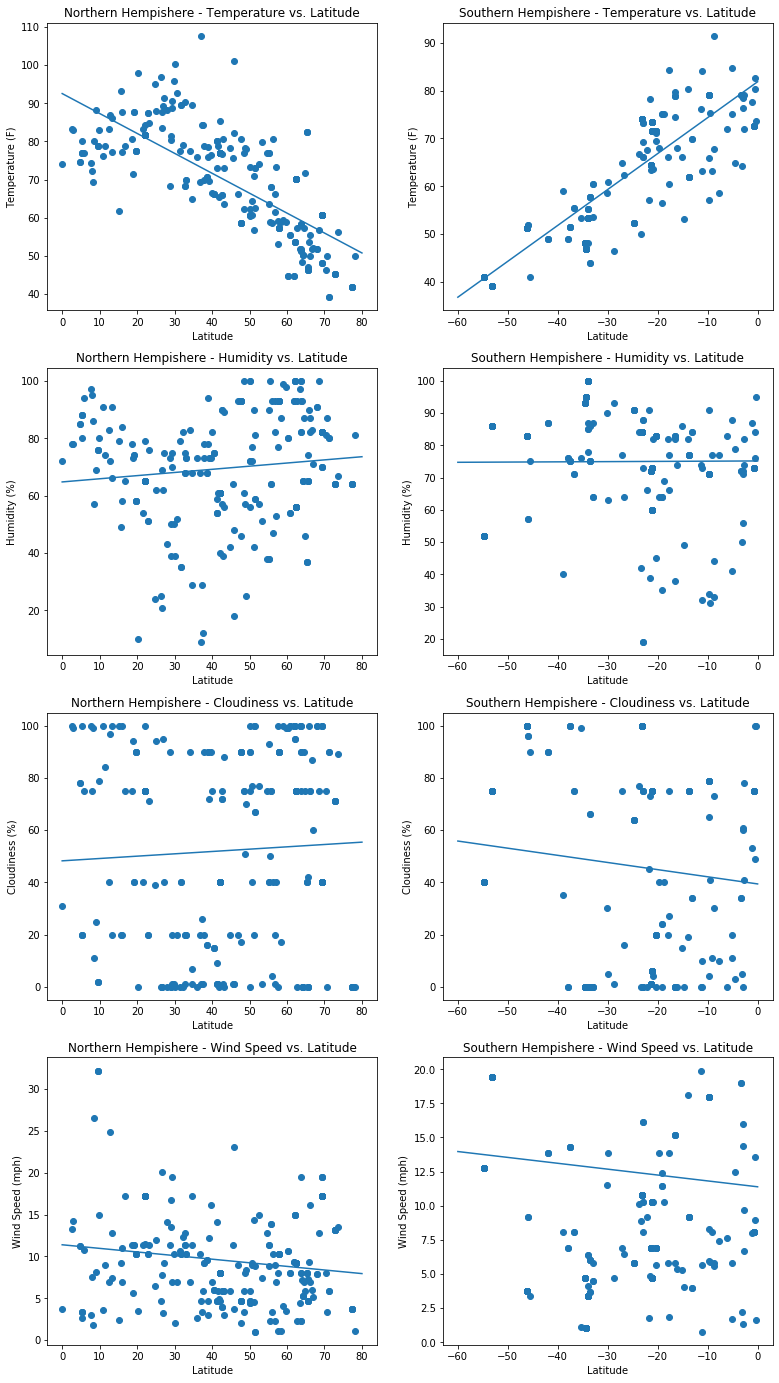

In [6]:
#create a blank dataframe with columns
cities_df = pd.DataFrame()
cities_df["City"] = list_of_cities
cities_df["Longitude"] = list_of_long
cities_df["Latitude"] = list_of_lat
cities_df["Temperature (F)"] = list_of_temp
cities_df["Humidity (%)"] = list_of_humid
cities_df["Cloudiness (%)"] = list_of_cloudy
cities_df["Wind Speed (mph)"] = list_of_wind

#sort by latitude
cities_df = cities_df.sort_values("Latitude")

#print to CSV
cities_df.to_csv(r"Results\WeatherData.csv", sep="\t")

#create true/false arrays to split the DF by north and south hemisphere
is_northern_hemisphere = cities_df["Latitude"] >= 0
is_southern_hemisphere = cities_df["Latitude"] <= 0

#split the df into north/south DF
cities_df_north = cities_df[is_northern_hemisphere]
cities_df_south = cities_df[is_southern_hemisphere]

#create lists of the data we need for easier plotting
list_of_lat_n = cities_df_north["Latitude"].tolist()
list_of_temp_n = cities_df_north["Temperature (F)"].tolist()
list_of_humid_n = cities_df_north["Humidity (%)"].tolist()
list_of_cloudy_n = cities_df_north["Cloudiness (%)"].tolist()
list_of_wind_n = cities_df_north["Wind Speed (mph)"].tolist()

list_of_lat_s = cities_df_south["Latitude"].tolist()
list_of_temp_s = cities_df_south["Temperature (F)"].tolist()
list_of_humid_s = cities_df_south["Humidity (%)"].tolist()
list_of_cloudy_s = cities_df_south["Cloudiness (%)"].tolist()
list_of_wind_s = cities_df_south["Wind Speed (mph)"].tolist()

#create scatter plots
fig2, axs2 = plt.subplots(4, 2, figsize=(13,17))

#create the linear regression array
x1 = np.array(list_of_lat_n).reshape((-1, 1))
y1 = np.array(list_of_temp_n)
model1 = LinearRegression()
model1.fit(x1, y1)
x1_new = np.linspace(0, 80)
y1_new = model1.predict(x1_new[:, np.newaxis])

#plot to screen
axs2[0, 0].scatter(list_of_lat_n, list_of_temp_n)
axs2[0, 0].plot(x1_new, y1_new)
axs2[0, 0].set_title('Northern Hempishere - Temperature vs. Latitude')
axs2[0, 0].set_ylabel('Temperature (F)')
axs2[0, 0].set_xlabel('Latitude')

#repeat
x2 = np.array(list_of_lat_s).reshape((-1, 1))
y2 = np.array(list_of_temp_s)
model2 = LinearRegression()
model2.fit(x2, y2)
x2_new = np.linspace(-60, 0, 100)
y2_new = model2.predict(x2_new[:, np.newaxis])

axs2[0, 1].scatter(list_of_lat_s, list_of_temp_s)
axs2[0, 1].plot(x2_new, y2_new)
axs2[0, 1].set_title('Southern Hempishere - Temperature vs. Latitude')
axs2[0, 1].set_ylabel('Temperature (F)')
axs2[0, 1].set_xlabel('Latitude')

## the temperature from the Southern hemisphere seems to directly correlate with how far the location is from the equator.
## since I am running this in summer, it makes sense the Northern hemisphere temperatures are peaking at the tropic of cancer, which is where the sun is highest in the summer months

x3 = np.array(list_of_lat_n).reshape((-1, 1))
y3 = np.array(list_of_humid_n)
model3 = LinearRegression()
model3.fit(x3, y3)
x3_new = np.linspace(0, 80, 100)
y3_new = model3.predict(x3_new[:, np.newaxis])

axs2[1, 0].scatter(list_of_lat_n, list_of_humid_n)
axs2[1, 0].plot(x3_new, y3_new)
axs2[1, 0].set_title('Northern Hempishere - Humidity vs. Latitude')
axs2[1, 0].set_ylabel('Humidity (%)')
axs2[1, 0].set_xlabel('Latitude')

x4 = np.array(list_of_lat_s).reshape((-1, 1))
y4 = np.array(list_of_humid_s)
model4 = LinearRegression()
model4.fit(x4, y4)
x4_new = np.linspace(-60, 0, 100)
y4_new = model4.predict(x4_new[:, np.newaxis])

axs2[1, 1].scatter(list_of_lat_s, list_of_humid_s)
axs2[1, 1].plot(x4_new, y4_new)
axs2[1, 1].set_title('Southern Hempishere - Humidity vs. Latitude')
axs2[1, 1].set_ylabel('Humidity (%)')
axs2[1, 1].set_xlabel('Latitude')

## not seeing a correlation between latitude and humidity, again I think this is depedant on geography (proximity to oceans/water/etc)

x5 = np.array(list_of_lat_n).reshape((-1, 1))
y5 = np.array(list_of_cloudy_n)
model5 = LinearRegression()
model5.fit(x5, y5)
x5_new = np.linspace(0, 80, 100)
y5_new = model5.predict(x5_new[:, np.newaxis])

axs2[2, 0].scatter(list_of_lat_n, list_of_cloudy_n)
axs2[2, 0].plot(x5_new, y5_new)
axs2[2, 0].set_title('Northern Hempishere - Cloudiness vs. Latitude')
axs2[2, 0].set_ylabel('Cloudiness (%)')
axs2[2, 0].set_xlabel('Latitude')

x6 = np.array(list_of_lat_s).reshape((-1, 1))
y6 = np.array(list_of_cloudy_s)
model6 = LinearRegression()
model6.fit(x6, y6)
x6_new = np.linspace(-60, 0, 100)
y6_new = model6.predict(x6_new[:, np.newaxis])

axs2[2, 1].scatter(list_of_lat_s, list_of_cloudy_s)
axs2[2, 1].plot(x6_new, y6_new)
axs2[2, 1].set_title('Southern Hempishere - Cloudiness vs. Latitude')
axs2[2, 1].set_ylabel('Cloudiness (%)')
axs2[2, 1].set_xlabel('Latitude')

#not seeing a correlation

x7 = np.array(list_of_lat_n).reshape((-1, 1))
y7 = np.array(list_of_wind_n)
model7 = LinearRegression()
model7.fit(x7, y7)
x7_new = np.linspace(0, 80, 100)
y7_new = model7.predict(x7_new[:, np.newaxis])

axs2[3, 0].scatter(list_of_lat_n, list_of_wind_n)
axs2[3, 0].plot(x7_new, y7_new)
axs2[3, 0].set_title('Northern Hempishere - Wind Speed vs. Latitude')
axs2[3, 0].set_ylabel('Wind Speed (mph)')
axs2[3, 0].set_xlabel('Latitude')

x8 = np.array(list_of_lat_n).reshape((-1, 1))
y8 = np.array(list_of_wind_n)
model8 = LinearRegression()
model8.fit(x8, y8)
x8_new = np.linspace(-60, 0, 100)
y8_new = model8.predict(x8_new[:, np.newaxis])

axs2[3, 1].scatter(list_of_lat_s, list_of_wind_s)
axs2[3, 1].plot(x8_new, y8_new)
axs2[3, 1].set_title('Southern Hempishere - Wind Speed vs. Latitude')
axs2[3, 1].set_ylabel('Wind Speed (mph)')
axs2[3, 1].set_xlabel('Latitude')

#higher wind speeds in the Southern hemisphere, could be due to the fact it's winter there right now (July)

#adjust size of subplots or else the title of the one below overlaps the X-axis label
plt.subplots_adjust(bottom=-0.2)

#save as PNG to results folder
plt.savefig("Results/plot.png")